# Problem Statement

#### ABC Bank Ltd. intends to build an in-house risk model to make lending decisions for subprime mortages.

### Business Objective is to maximize the profitability, given

* Profit from good customer is 100 dollar 
* Loss from a bad customer is 500 dollar

In [571]:
pip install toad

Note: you may need to restart the kernel to use updated packages.


In [158]:
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import toad
from toad.plot import bin_plot
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report, auc
from toad.metrics import KS, AUC
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_excel('CreditScoring.xlsx')
df.head()

,TARGET,ID,DerogCnt,CollectCnt,BanruptcyInd,InqCnt06,InqTimeLast,InqFinanceCnt24,TLTimeFirst,TLTimeLast,...,TL50UtilCnt,TLBalHCPct,TLSatPct,TLDel3060Cnt24,TLDel90Cnt24,TLDel60CntAll,TLOpenPct,TLBadDerogCnt,TLDel60Cnt24,TLOpen24Pct
0,1,582,3,3,0,4,0.0,5,117,27,...,3.0,0.9179,0.2083,2,3,7,0.2083,4,4,0.0000
1,1,662,15,9,0,3,1.0,3,14,14,...,1.0,0.8000,0.0000,0,0,0,1.0000,12,0,1.0000
2,1,805,0,0,0,1,5.0,1,354,7,...,5.0,0.3552,0.6538,0,1,1,0.7308,1,1,0.5263
3,1,1175,8,5,0,6,1.0,10,16,4,...,3.0,0.9127,0.2500,1,1,1,0.7500,7,1,1.3333
4,1,1373,3,1,0,9,0.0,8,130,52,...,1.0,1.2511,0.0000,0,1,4,0.1429,3,1,0.0000


In [12]:
df.shape

(3000, 30)

# Data Understanding

### Some Important Finance Terms Used
* **Bankruptcy Indicator:** Number indicating borrower's likelihood of filing for bankruptcy.
* **Public Deragatories:** Count of late Payments or Defaults.
* **Financial Enquiries:** Count of credit enquiries made in last few months.
* **Trade Line:** Is a number indicating the numbers of credit accounts a borrower has, be it: loan, credit card, or other debt obligations. So, basically if you have a credit card and a home loan at a certain point in time, you have 2 trade lines open.


### Features Descriptions
* **Target:** 1 (Defaulters), 0 (Good Loans)
* **ID:** Customer ID
* **DerogCnt:** Number of Public Derogatories
* **CollectCnt:** Collections
* **BanruptcyInd:** Bankruptcy Indicator
* **InqCnt06:** Inquiries 6 Months
* **InqTimeLast:** Time since Last Inquiry
* **InqFinanceCnt24:** Finance Inquires 24 Month
* **TLTimeFirst:** Time since First  Trade Une     
* **TLTimeLast:** Time since Last Trade Une 
* **TLCnt03:** Number Trade Unes opened 3 months
* **TLCnt12:** Number Trade Unes opened 12 months
* **TLCnt24:** Number Trade Unes opened 24 months
* **TLCnt:** Total open Trade Unes
* **TLSum:** Total Balance All Teade Lines
* **TLMaxSum:** Total High Credit All Trade Lines
* **TLSatCnt:** Number Trade Lines Currently Satisfactory
* **TLDel60Cnt:** Number Trade Unes Currently 60 Days or Worse
* **TLBadCnt24:** Number Trade Unes Bad Debt 24 Months
* **TL75UtilCnt:** Number Trade Unes 75 pct Utilized
* **TL50UtilCnt:** Number Trade Unes 50 pct Utilized      
* **TLBalHCPct:** Percent Trade Line Balance to High Credit
* **TLSatPct:** Percent Satisfactory to Total Trade Lines
* **TLDel3060Cnt24:** Number Trade Lines 30 or 60 Days 24 Months   
* **TLDel90Cnt24:** Number Trade Lines 90+ 24 Month
* **TLDel60CntAll:** Number Trade Lines 60 Days or Worse ever  
* **TLOpenPct:** Percent Trade Lines open
* **TLBadDerogCnt:** Bad Debt + Public Derogatories
* **TLDel60Cnt24:** Number Trade Lines 60 Days or Worse 24 Months
* **TLOpen24Pct:** Percent Trade Unes Open 24 Months 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET           3000 non-null   int64  
 1   ID               3000 non-null   int64  
 2   DerogCnt         3000 non-null   int64  
 3   CollectCnt       3000 non-null   int64  
 4   BanruptcyInd     3000 non-null   int64  
 5   InqCnt06         3000 non-null   int64  
 6   InqTimeLast      2812 non-null   float64
 7   InqFinanceCnt24  3000 non-null   int64  
 8   TLTimeFirst      3000 non-null   int64  
 9   TLTimeLast       3000 non-null   int64  
 10  TLCnt03          3000 non-null   int64  
 11  TLCnt12          3000 non-null   int64  
 12  TLCnt24          3000 non-null   int64  
 13  TLCnt            2997 non-null   float64
 14  TLSum            2960 non-null   float64
 15  TLMaxSum         2960 non-null   float64
 16  TLSatCnt         2996 non-null   float64
 17  TLDel60Cnt    

In [14]:
df.nunique()

TARGET                2
ID                 3000
DerogCnt             26
CollectCnt           24
BanruptcyInd          2
InqCnt06             30
InqTimeLast          25
InqFinanceCnt24      37
TLTimeFirst         419
TLTimeLast           97
TLCnt03               7
TLCnt12              14
TLCnt24              26
TLCnt                34
TLSum              2767
TLMaxSum           2797
TLSatCnt             51
TLDel60Cnt           21
TLBadCnt24           16
TL75UtilCnt          20
TL50UtilCnt          23
TLBalHCPct         2377
TLSatPct            347
TLDel3060Cnt24        5
TLDel90Cnt24         16
TLDel60CntAll        24
TLOpenPct           324
TLBadDerogCnt        20
TLDel60Cnt24         17
TLOpen24Pct         197
dtype: int64

In [15]:
df['TARGET'].value_counts()

0    2500
1     500
Name: TARGET, dtype: int64

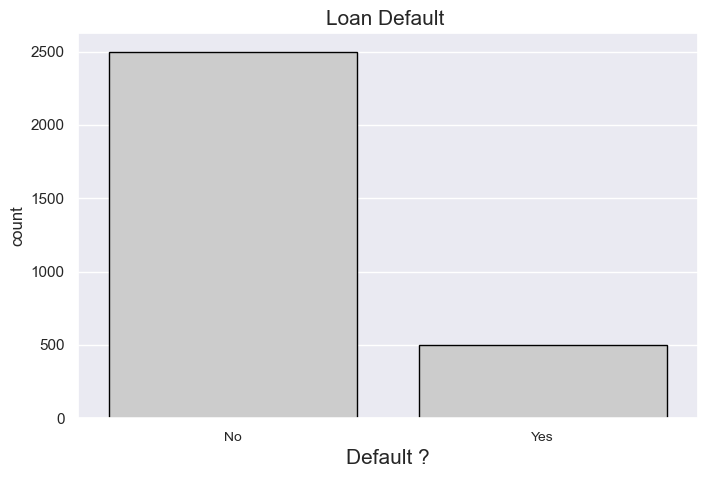

In [16]:
plt.figure(figsize = (8,5))
sns.countplot(x='TARGET',data=df, color = '0.8', edgecolor='black')
plt.title("Loan Default ",fontsize=15)
plt.xlabel('Default ?', fontsize=15)
plt.xticks([0, 1], ['No', 'Yes'], fontsize=10) 
plt.show()

* It's a unbalanced dataset, should perform upsampling

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5]),
 [Text(0, 0.5, 'TARGET'),
  Text(0, 1.5, 'DerogCnt'),
  Text(0, 2.5, 'CollectCnt'),
  Text(0, 3.5, 'BanruptcyInd'),
  Text(0, 4.5, 'InqCnt06'),
  Text(0, 5.5, 'InqTimeLast'),
  Text(0, 6.5, 'InqFinanceCnt24'),
  Text(0, 7.5, 'TLTimeFirst'),
  Text(0, 8.5, 'TLTimeLast'),
  Text(0, 9.5, 'TLCnt03'),
  Text(0, 10.5, 'TLCnt12'),
  Text(0, 11.5, 'TLCnt24'),
  Text(0, 12.5, 'TLCnt'),
  Text(0, 13.5, 'TLSum'),
  Text(0, 14.5, 'TLMaxSum'),
  Text(0, 15.5, 'TLSatCnt'),
  Text(0, 16.5, 'TLDel60Cnt'),
  Text(0, 17.5, 'TLBadCnt24'),
  Text(0, 18.5, 'TL75UtilCnt'),
  Text(0, 19.5, 'TL50UtilCnt'),
  Text(0, 20.5, 'TLBalHCPct'),
  Text(0, 21.5, 'TLSatPct'),
  Text(0, 22.5, 'TLDel3060Cnt24'),
  Text(0, 23.5, 'TLDel90Cnt24'),
  Text(0, 24.5, 'TLDel60CntAll'),
  Text(0, 25.5, 'TLOpenPct'),
  Text(0, 26.5, 'T

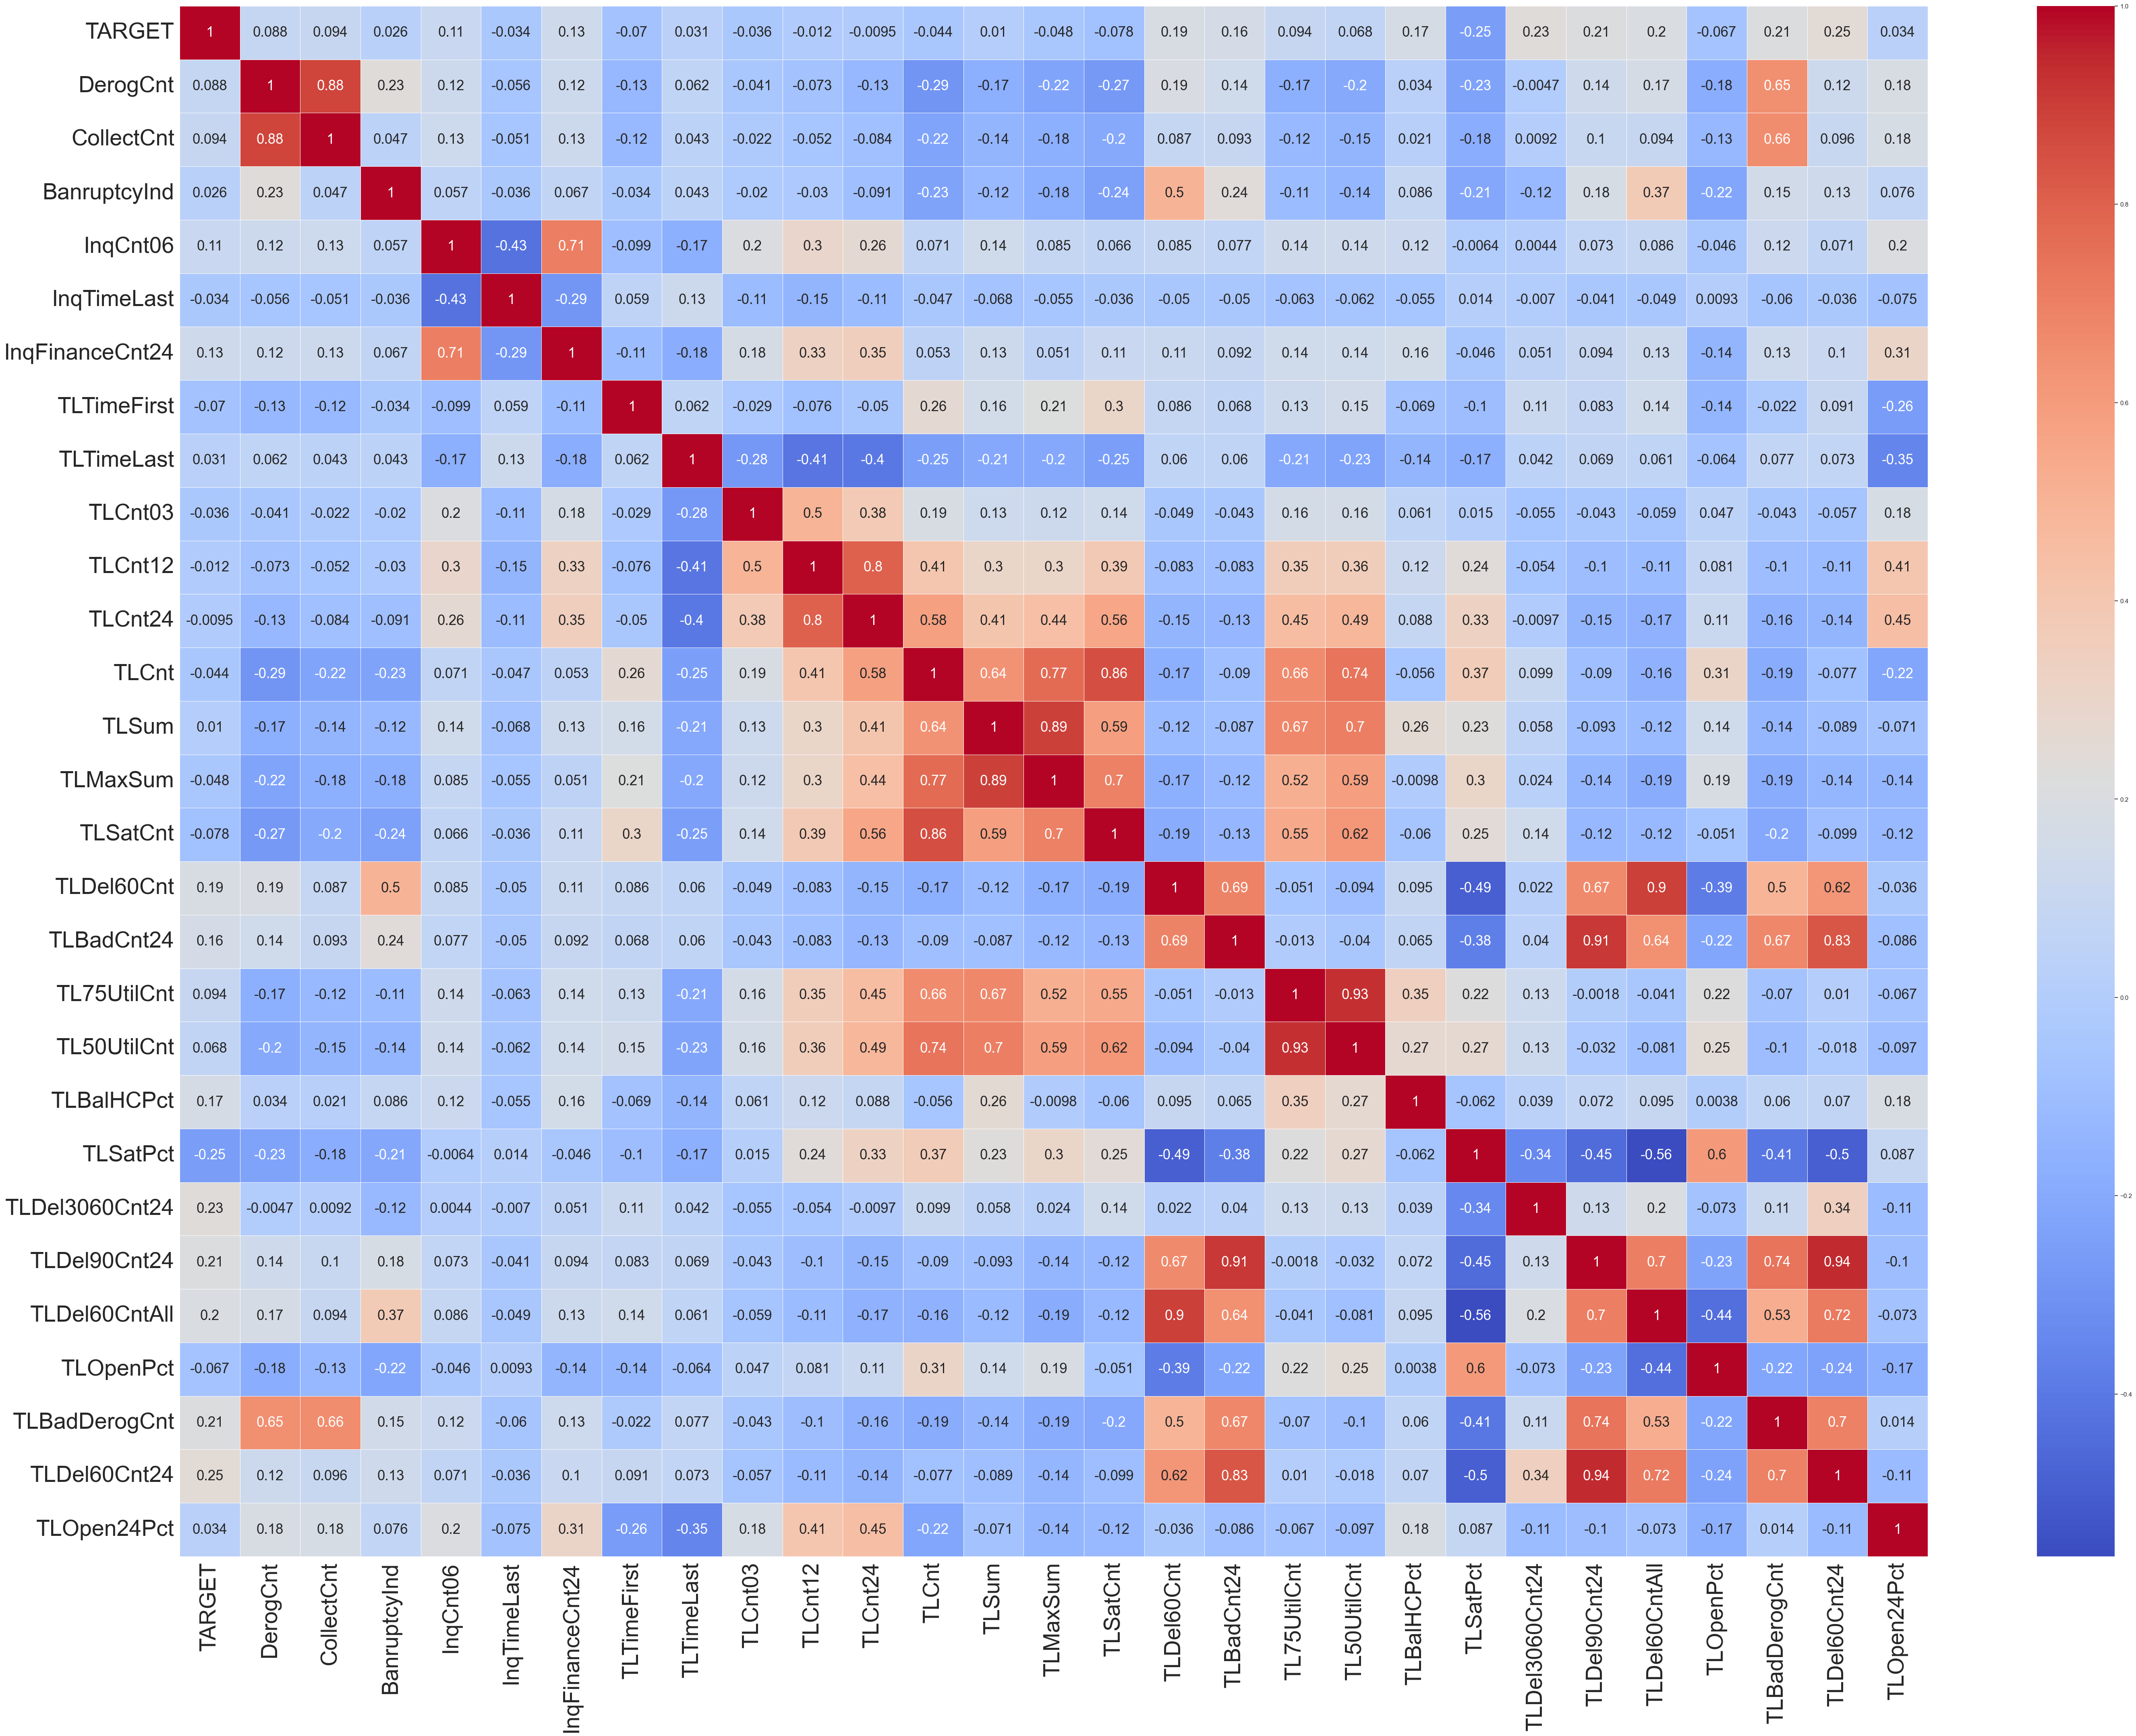

In [17]:
plt.figure(figsize = (70,50))
sns.heatmap(df.drop('ID',axis=1).corr(), cmap='coolwarm', annot=True, linewidths=0.5, annot_kws={'size': 25})
plt.xticks(fontsize=40, rotation=90)
plt.yticks(fontsize=40, rotation=0)

* TLDel60CntAll & TLDel60Cnt are highly correlated (0.90)
* TLDel90Cnt24 & TLBadCnt24 are highly correlated (0.91)
* TL75UtilCnt & TL50UtilCnt are highly correlated (0.93)
* TLDel60Cnt24 & TLDel90Cnt24 are highly correlated (0.94)

In [18]:
df.isna().mean()*100

TARGET             0.000000
ID                 0.000000
DerogCnt           0.000000
CollectCnt         0.000000
BanruptcyInd       0.000000
InqCnt06           0.000000
InqTimeLast        6.266667
InqFinanceCnt24    0.000000
TLTimeFirst        0.000000
TLTimeLast         0.000000
TLCnt03            0.000000
TLCnt12            0.000000
TLCnt24            0.000000
TLCnt              0.100000
TLSum              1.333333
TLMaxSum           1.333333
TLSatCnt           0.133333
TLDel60Cnt         0.000000
TLBadCnt24         0.000000
TL75UtilCnt        3.300000
TL50UtilCnt        3.300000
TLBalHCPct         1.366667
TLSatPct           0.133333
TLDel3060Cnt24     0.000000
TLDel90Cnt24       0.000000
TLDel60CntAll      0.000000
TLOpenPct          0.100000
TLBadDerogCnt      0.000000
TLDel60Cnt24       0.000000
TLOpen24Pct        0.100000
dtype: float64

* Since %age missing values is only around 3%, therefore drop all missing value rows

In [19]:
df.dropna(inplace=True)
df.isna().mean()*100

TARGET             0.0
ID                 0.0
DerogCnt           0.0
CollectCnt         0.0
BanruptcyInd       0.0
InqCnt06           0.0
InqTimeLast        0.0
InqFinanceCnt24    0.0
TLTimeFirst        0.0
TLTimeLast         0.0
TLCnt03            0.0
TLCnt12            0.0
TLCnt24            0.0
TLCnt              0.0
TLSum              0.0
TLMaxSum           0.0
TLSatCnt           0.0
TLDel60Cnt         0.0
TLBadCnt24         0.0
TL75UtilCnt        0.0
TL50UtilCnt        0.0
TLBalHCPct         0.0
TLSatPct           0.0
TLDel3060Cnt24     0.0
TLDel90Cnt24       0.0
TLDel60CntAll      0.0
TLOpenPct          0.0
TLBadDerogCnt      0.0
TLDel60Cnt24       0.0
TLOpen24Pct        0.0
dtype: float64

# Train-Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('TARGET', axis=1), df['TARGET'], test_size=0.2, 
                                                    random_state=0, stratify=df['TARGET'])

In [21]:
y_train.mean(), y_test.mean()

(0.17277726856095327, 0.17216117216117216)

* Almost same distribution of **TARGET** column in Test and Train datasets

In [22]:
X_train.drop('ID', inplace=True, axis=1)
X_test.drop('ID', inplace=True, axis=1)
X_train.shape

(2182, 28)

# Feature Filtering

Conduct preliminary feature selection according to IV (Information Value) and correlation (with other features), the variables are:

* iv=0.02: the features with IV smaller than 0.02 are eliminated;
* corr=0.9: if two or more features have Pearson correlation larger than 0.7, the ones with lower IV are eliminated;
* return_drop=False: if set True, the function returns a list of deleted columns;

In [23]:
train_selected, drop_list = toad.selection.select(X_train, target = y_train, 
                                      iv = 0.02, corr = 0.9, 
                                      return_drop=True)

print(train_selected.shape)

(2182, 24)


In [24]:
drop_list

{'empty': array([], dtype=float64),
 'iv': array(['BanruptcyInd', 'TLCnt03'], dtype=object),
 'corr': array(['TL50UtilCnt', 'TLDel90Cnt24'], dtype=object)}

In [25]:
print("Keep:",train_selected.shape[1])
print("Drop due to low IV:",len(drop_list['iv']))
print("Drop due to high correlation:",len(drop_list['corr']))

Keep: 24
Drop due to low IV: 2
Drop due to high correlation: 2


In [26]:
IV_values = toad.quality(train_selected, y_train, iv_only=True)
IV_values = IV_values['iv']
IV_values

TLDel60Cnt24       0.563718
TLSatPct           0.469613
TLBadDerogCnt      0.405168
TLDel60CntAll      0.362760
TLDel60Cnt         0.348011
TLDel3060Cnt24     0.336824
TLBadCnt24         0.311627
TLBalHCPct         0.306793
InqFinanceCnt24    0.227969
TLTimeFirst        0.183328
InqCnt06           0.180865
TL75UtilCnt        0.160068
TLSatCnt           0.150231
TLMaxSum           0.137544
CollectCnt         0.135368
TLOpen24Pct        0.110214
TLSum              0.102773
TLOpenPct          0.100971
DerogCnt           0.098903
TLTimeLast         0.095936
TLCnt              0.061616
TLCnt12            0.051344
InqTimeLast        0.051093
TLCnt24            0.047355
Name: iv, dtype: float64

Following Features have strong predctive power (IV>3) for the TARGET
* TLDel60Cnt24
* TLSatPct
* TLBadDerogCnt
* TLDel60CntAll
* TLDel60Cnt
* TLDel3060Cnt24
* TLBadCnt24
* TLBalHCPct

# Feature Binning

Feature binning is to transform a continuous or numerical variable into a categorical feature.
* It simplifies the logistic regression model and reduces the risk of model overfitting
* Logistic regression is a generalized linear model, and its expressive ability is limited; Feature binning can introduce nonlinearity into the model, which can improve the expressive ability of the model and help better model fitting
* The discretized features are very robust to abnormal data: for example, a feature is 1 if age > 30, and 0 otherwise. If the features are not discretized, an abnormal data point "300 years old" will impact the model fitting
* It can treat null data as an individual class

### Steps for feature binning:
#### Step 1. Initialization: c = toad.transform.Combiner() 
#### Step 2. Training binning: 
c.fit(dataframe, 
      y = 'target', 
      method = 'chi', 
      min_samples = 0.05, 
      n_bins = None, 
      empty_separate = False)
* y: target column
* method: binning method, supports chi (chi-square binning), dt (decision tree binning), kmean, quantile, step (equal step size binning)
* min_samples: Each box contains the least number of samples, which can be a number or a proportion 
* n_bins: the number of bins; If it is not possible to divide so many boxes the maximum number of bins will be divided.
* empty_separate: Whether to separate empty boxes separately 

#### Step 3. check binning nodes: c.export() 
#### Step 4. Manually adjust binning: c.load(dict) 
#### Step 5. Apply binning results: c.transform(dataframe, labels=False)
* labels: Whether to convert the binning results into box labels. If False, output 0, 1, 2… (discrete variables are sorted according to the proportion), and if True output (-inf, 0], (0,10], (10, inf).

In [27]:
combiner = toad.transform.Combiner()

combiner.fit(X=train_selected,
             y=y_train,
             method='chi',
             min_samples = 0.05)

In [28]:
bins = combiner.export()
bins

{'DerogCnt': [2, 4],
 'CollectCnt': [1, 2, 3],
 'InqCnt06': [1, 2, 3, 5, 10],
 'InqTimeLast': [1.0, 4.0, 7.0, 12.0],
 'InqFinanceCnt24': [2, 6],
 'TLTimeFirst': [196],
 'TLTimeLast': [10, 30],
 'TLCnt12': [1, 4],
 'TLCnt24': [1, 2, 3, 6, 11],
 'TLCnt': [7.0, 13.0],
 'TLSum': [28743.0],
 'TLMaxSum': [14864.0, 39791.0],
 'TLSatCnt': [],
 'TLDel60Cnt': [1, 2],
 'TLBadCnt24': [1, 2, 3],
 'TL75UtilCnt': [3.0],
 'TLBalHCPct': [0.6726, 0.8702],
 'TLSatPct': [0.3, 0.4688],
 'TLDel3060Cnt24': [1, 2, 3],
 'TLDel60CntAll': [1, 2, 8],
 'TLOpenPct': [0.4688, 0.5277999999999999],
 'TLBadDerogCnt': [1, 2],
 'TLDel60Cnt24': [1, 2],
 'TLOpen24Pct': [0.0769, 0.28569999999999995, 0.7999999999999999]}

In [29]:
df['TLSatCnt'].describe()

count    2728.000000
mean       13.975440
std         8.941511
min         0.000000
25%         7.000000
50%        13.000000
75%        19.000000
max        57.000000
Name: TLSatCnt, dtype: float64

* TLSatCnt has no bin, Therefore dropped in binning

In [30]:
train_selected_bin = combiner.transform(train_selected)
test_bin = combiner.transform(X_test[train_selected_bin.columns])

train_selected_bin.drop('TLSatCnt', inplace=True, axis=1)
test_bin.drop('TLSatCnt', inplace=True, axis=1)

In [31]:
train_selected_bin.head()

,DerogCnt,CollectCnt,InqCnt06,InqTimeLast,InqFinanceCnt24,TLTimeFirst,TLTimeLast,TLCnt12,TLCnt24,TLCnt,...,TLBadCnt24,TL75UtilCnt,TLBalHCPct,TLSatPct,TLDel3060Cnt24,TLDel60CntAll,TLOpenPct,TLBadDerogCnt,TLDel60Cnt24,TLOpen24Pct
763,0,0,3,1,1,1,0,1,2,0,...,0,1,0,1,3,2,0,0,2,2
1275,2,3,4,1,1,1,1,1,3,0,...,0,0,0,2,0,0,0,2,0,3
854,0,0,1,1,0,0,0,1,1,0,...,0,0,1,2,0,0,2,0,0,3
1301,0,1,2,1,0,1,1,0,2,1,...,0,0,0,2,0,0,0,0,0,1
830,1,2,1,2,0,0,1,0,0,0,...,3,0,0,0,0,2,0,2,2,0


## WOE(Weight of Evidence) Transformation

WOE transformation is applied after binning is tuned and finalised. The procedure is following:

* **Use the finalised Combiner to apply the binning:** c.transform(dataframe, labels=False)

It only transform the binned features.

* **initialise woe transer:** transer = toad.transform.WOETransformer()

* **fit_transform:** transer.fit_transform(dataframe, target, exclude = None)

Fit and apply WOE transformation, for in-sample data

* target：target values in Series or DataFrame;
    * 1. “fit_transform” fits and transform all the data, even the ones not binned. Remember to exclude the unwanted columns. 
    * 2. Alwasy exlclude target column.


* **Apply WOE transformation, typically to test data：**transer.transform(dataframe)

In [32]:
t=toad.transform.WOETransformer()

train_woe = t.fit_transform(X=train_selected_bin,
                            y=y_train)

test_woe = t.transform(test_bin)

In [33]:
train_woe.head()

,DerogCnt,CollectCnt,InqCnt06,InqTimeLast,InqFinanceCnt24,TLTimeFirst,TLTimeLast,TLCnt12,TLCnt24,TLCnt,...,TLBadCnt24,TL75UtilCnt,TLBalHCPct,TLSatPct,TLDel3060Cnt24,TLDel60CntAll,TLOpenPct,TLBadDerogCnt,TLDel60Cnt24,TLOpen24Pct
763,-0.176044,-0.216165,0.154330,0.008176,0.047052,-0.411588,-0.159439,-0.142004,0.034136,0.125986,...,-0.346205,0.223451,-0.478477,0.267716,0.957607,0.481710,0.158432,-0.651521,0.917624,-0.163769
1275,0.273302,0.417448,0.393589,0.008176,0.047052,-0.411588,0.179776,-0.142004,-0.163749,0.125986,...,-0.346205,-0.283430,-0.478477,-0.580792,-0.461303,-0.837768,0.158432,0.688411,-0.796447,0.228784
854,-0.176044,-0.216165,-0.543524,0.008176,-0.458508,0.182421,-0.159439,-0.142004,-0.083300,0.125986,...,-0.346205,-0.283430,0.077994,-0.580792,-0.461303,-0.837768,-0.131560,-0.651521,-0.796447,0.228784
1301,-0.176044,0.153607,-0.376587,0.008176,-0.458508,-0.411588,0.179776,0.242636,0.034136,-0.128190,...,-0.346205,-0.283430,-0.478477,-0.580792,-0.461303,-0.837768,0.158432,-0.651521,-0.796447,-0.171793
830,0.452249,0.683682,-0.543524,-0.488053,-0.458508,0.182421,0.179776,0.242636,0.378511,0.125986,...,0.688620,-0.283430,-0.478477,0.935101,-0.461303,0.481710,0.158432,0.688411,0.917624,0.392338


## Calculate PSI
* PSI (Population Stability Index) reflects the stability of the distribution. We often use it to screen features and evaluate model stability. The industry level is to drop features with a PSI greater than 0.25

In [34]:
features_list = [feat for feat in train_woe.columns]

psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list]).sort_values(0)

psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' :'feature', 0:'psi'})

In [35]:
psi_df

,feature,psi
0,TLDel60Cnt,0.000743
1,TLOpen24Pct,0.000787
2,TLBalHCPct,0.000988
3,TLDel3060Cnt24,0.001078
4,TL75UtilCnt,0.001554
5,TLOpenPct,0.001757
6,TLSatPct,0.001841
7,TLCnt24,0.002496
8,InqFinanceCnt24,0.002729
9,TLBadDerogCnt,0.002736


* None of the features has PSI > 0.25, So no need to remove any feature

In [36]:
WOE_IV_values = toad.quality(train_selected_bin, y_train, iv_only=True)
WOE_IV_values = WOE_IV_values['iv']
WOE_IV_values

TLDel60Cnt24       0.536286
TLSatPct           0.396203
TLBadDerogCnt      0.344819
TLDel3060Cnt24     0.336824
TLDel60CntAll      0.336527
TLDel60Cnt         0.310572
TLBadCnt24         0.271979
TLBalHCPct         0.190576
InqCnt06           0.143211
InqFinanceCnt24    0.131982
CollectCnt         0.095783
TLTimeFirst        0.074616
DerogCnt           0.068710
TL75UtilCnt        0.063001
TLOpen24Pct        0.047202
TLTimeLast         0.045277
InqTimeLast        0.030293
TLCnt24            0.028775
TLCnt12            0.027977
TLOpenPct          0.024046
TLMaxSum           0.021382
TLCnt              0.014507
TLSum              0.014443
Name: iv, dtype: float64

# Model Building

In [97]:
lr = LogisticRegression()

* **penalty:** This specifies type of regularization used in logistic regression. It can be set to 'l1', 'l2', 'elasticnet', or 'none'. 'l1' and 'l2' refer to L1 (Lasso) and L2 (Ridge) regularization, respectively. 'elasticnet' allows a combination of L1 and L2 regularization. 'none' means no regularization.
* **C:** This is the inverse of the regularization strength. A smaller value of C implies stronger regularization.You may need to tune this parameter to find the right balance between fitting the data and preventing overfitting.
* **solver:** The solver algorithm used to optimize the logistic regression. Common options are 'lbfgs', 'liblinear', 'sag', 'saga', and 'newton-cg'. The choice of solver can affect the performance and speed of convergence.
* **max_iter:** The maximum number of iterations for the solver to converge. You may need to adjust this if the solver is not converging or converging too slowly.

In [98]:
params_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-3, 3, 100),
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
    'max_iter': np.arange(100, 1000, 100)
}

In [99]:
lr_random = RandomizedSearchCV(estimator = lr, param_distributions = params_lr, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = 1)

lr_random.fit(train_woe, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=187.3817422860383, max_iter=700, penalty=none, solver=lbfgs; total time=   0.1s
[CV] END C=187.3817422860383, max_iter=700, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=187.3817422860383, max_iter=700, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=187.3817422860383, max_iter=700, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=187.3817422860383, max_iter=700, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001747528400007683, max_iter=800, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001747528400007683, max_iter=800, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001747528400007683, max_iter=800, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001747528400007683, max_iter=800, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001747528400007683, max_iter=800, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.057223676

[CV] END C=0.008111308307896872, max_iter=300, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.008111308307896872, max_iter=300, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.008111308307896872, max_iter=300, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.008111308307896872, max_iter=300, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.008111308307896872, max_iter=300, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.0011497569953977356, max_iter=100, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.0011497569953977356, max_iter=100, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.0011497569953977356, max_iter=100, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.0011497569953977356, max_iter=100, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.0011497569953977356, max_iter=100, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.0093260334688322, max_iter=700, penalty=l2, solver=l

[CV] END C=187.3817422860383, max_iter=700, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=572.236765935022, max_iter=300, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END C=572.236765935022, max_iter=300, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END C=572.236765935022, max_iter=300, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END C=572.236765935022, max_iter=300, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END C=572.236765935022, max_iter=300, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END C=11.497569953977356, max_iter=800, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=11.497569953977356, max_iter=800, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=11.497569953977356, max_iter=800, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=11.497569953977356, max_iter=800, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=11.497569953977356, max_iter=800, penalty=l2, solver=lib

[CV] END C=0.3511191734215131, max_iter=400, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.3511191734215131, max_iter=400, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.3511191734215131, max_iter=400, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.002009233002565048, max_iter=600, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.002009233002565048, max_iter=600, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.002009233002565048, max_iter=600, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.002009233002565048, max_iter=600, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.002009233002565048, max_iter=600, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.7054802310718645, max_iter=400, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.7054802310718645, max_iter=400, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.7054802310718645, max_iter=

[CV] END C=0.6135907273413176, max_iter=600, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.6135907273413176, max_iter=600, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.6135907273413176, max_iter=600, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.6135907273413176, max_iter=600, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=23.10129700083158, max_iter=600, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=23.10129700083158, max_iter=600, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=23.10129700083158, max_iter=600, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=23.10129700083158, max_iter=600, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=23.10129700083158, max_iter=600, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=123.28467394420659, max_iter=800, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=123.28467394420659, max_iter=800, penalty=l2, solver=lbfgs; total time=   0.0s
[

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=1,
                   param_distributions={'C': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.3...
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                                        'max_iter': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['lbfgs', 'liblinear', 'sag',
                                                   'saga', 'newton-cg']},
                   random_state=42, verbose=2)

In [100]:
print(lr_random.best_params_)
print('score: {}' .format(lr_random.best_score_))

{'solver': 'saga', 'penalty': 'l1', 'max_iter': 200, 'C': 6.5793322465756825}
score: 0.83823084836143


* Best Parameters
    * solver: saga
    * penalty: l1
    * max_iter: 200
    * C: 6.5793322465756825
* **Accuracy: 83.82%**

In [101]:
lr = LogisticRegression(random_state=42, C= 6.5793322465756825, penalty='l1', solver='saga', max_iter=200)

lr = LogisticRegression(class_weight='balanced')
lr.fit(train_woe, y_train)

pred_train = lr.predict_proba(train_woe)[:,1]

print('train KS',KS(pred_train, y_train))
print('train AUC',AUC(pred_train, y_train))

pred_test =lr.predict_proba(test_woe)[:,1]
print('Test KS',KS(pred_OOT, y_test))
print('Test AUC',AUC(pred_OOT, y_test))

train KS 0.472681984173053
train AUC 0.7993056422992424
Test KS 0.45306910186405575
Test AUC 0.755107324421013


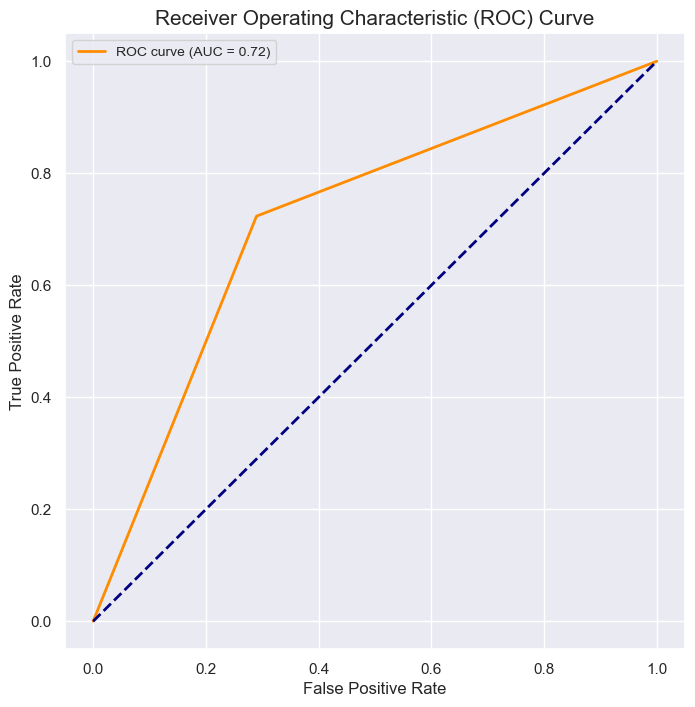

In [111]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict(test_woe))

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [133]:
# Create a GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Fit the model on the training data
gb_classifier.fit(train_woe, y_train)

feat_importances = pd.Series(gb_classifier.feature_importances_, index=train_woe.columns)
feat_importances.sort_values(ascending=False)

TLDel60Cnt24       0.189922
TLDel3060Cnt24     0.110349
InqCnt06           0.081288
TLSatPct           0.074853
TLBalHCPct         0.070079
TLTimeFirst        0.048420
TLDel60Cnt         0.045238
TLTimeLast         0.038489
TLOpen24Pct        0.035020
TL75UtilCnt        0.034105
TLBadCnt24         0.030040
CollectCnt         0.029158
TLDel60CntAll      0.028407
TLOpenPct          0.027848
TLSum              0.023442
InqFinanceCnt24    0.022256
TLCnt24            0.021380
TLBadDerogCnt      0.019714
InqTimeLast        0.017098
TLMaxSum           0.016101
TLCnt              0.013967
TLCnt12            0.012029
DerogCnt           0.010797
dtype: float64

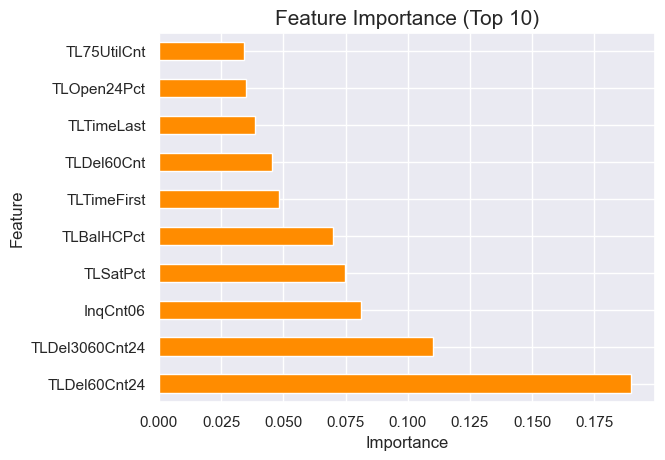

In [130]:
# Get feature importances
feat_importances.nlargest(10).plot(kind='barh', color='darkorange')
feat_importances.sort_values(ascending=False, inplace=True)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('Feature Importance (Top 10)', fontsize=15)
plt.show()

In [116]:
feature_importances

array([0.01079681, 0.02915778, 0.0812882 , 0.01709819, 0.02225554,
       0.04842018, 0.03848917, 0.0120289 , 0.02137979, 0.01396671,
       0.02344225, 0.01610085, 0.04523833, 0.03004011, 0.03410453,
       0.07007877, 0.07485278, 0.11034931, 0.02840736, 0.02784752,
       0.01971449, 0.18992226, 0.03502019])

# Scorecard Generation

#### Scorecard transformation is a technique which involves transforming the raw predictions or probabilities generated by the model into a scoring system or scorecard. The scorecard transformation process is valuable because it simplifies the complex predictions of a model into a more interpretable and actionable scoring system.

* **Step-1: Obtaining Raw Predictions/Probabilities:**

* **Step-2: Mapping Predictions to Scorecard Points:**
    *  mapping involves converting the range of predicted probabilities or scores into specific points or scores that are easier to interpret and use.

* **Step-3: Scoring Features Based on Coefficients or Importance:**
    * the coefficients may be used to assign weights to each feature. These weights can then be converted into points for the scorecard

* **Step-4: Creating Scorecard Points for Features:**
    * Assign points to each feature based on its contribution to the predicted outcome. The points are often based on the magnitude of coefficients, importance, or other measures of predictive power.

* **Step-5: Calculating Total Scores:**
    * Calculate the total score for an individual or instance by summing the points associated with each feature in the scorecard.

* **Step-6: Thresholds and Cutoffs:**
    * Define thresholds or cutoffs based on the total score to categorize individuals into different risk or credit categories (e.g., low risk, medium risk, high risk).

In [134]:
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,
    class_weight = 'balanced',
    C=0.1,
    base_score = 1000,
    base_odds = 35 ,
    pdo = 80,
    rate = 2
)

card.fit(train_woe, y_train)

ScoreCard(base_score=1000,
          combiner=<toad.transform.Combiner object at 0x162afa790>, pdo=80,
          transer=<toad.transform.WOETransformer object at 0x162816410>)

In [314]:
df['CreditScore'] = card.predict(df)
df['CreditScore'].describe()

count    2728.000000
mean      631.920816
std       125.671520
min       196.725284
25%       547.408098
50%       642.742839
75%       727.965535
max       919.481344
Name: CreditScore, dtype: float64

In [351]:
test = X_test
test['CreditScore'] = card.predict(X_test)
test = test.reset_index(drop=True)
test['CreditScore'].describe()

count    546.000000
mean     626.065695
std      123.670750
min      295.167004
25%      547.606505
50%      634.433877
75%      718.334457
max      919.481344
Name: CreditScore, dtype: float64

### Transform Scorecard into Dataframe

In [352]:
final_card_score=card.export()
keys = list(card.export().keys())
score_card_df = pd.DataFrame()
for n in keys:
    temp = pd.DataFrame.from_dict(final_card_score[n], orient='index')
    temp = temp.reset_index()
    temp.columns= ['binning','score']
    temp['variable'] = n
    temp = temp[['variable','binning','score']]
    score_card_df = score_card_df.append(temp)
score_card_df.head(20)

,variable,binning,score
0,DerogCnt,[-inf ~ 2),25.06
1,DerogCnt,[2 ~ 4),27.35
2,DerogCnt,[4 ~ inf),26.69
0,CollectCnt,[-inf ~ 1),32.95
1,CollectCnt,[1 ~ 2),20.54
2,CollectCnt,[2 ~ 3),2.75
3,CollectCnt,[3 ~ inf),11.69
0,InqCnt06,[-inf ~ 1),35.70
1,InqCnt06,[1 ~ 2),66.41
2,InqCnt06,[2 ~ 3),53.91


In [353]:
score_card_df.sort_values('score', ascending=False)[:15]

,variable,binning,score
1,InqCnt06,[1 ~ 2),66.41
0,TLDel3060Cnt24,[-inf ~ 1),64.84
0,TLBalHCPct,[-inf ~ 0.6726),63.56
1,TLTimeFirst,[196 ~ inf),61.72
0,TLDel60Cnt24,[-inf ~ 1),58.97
2,TLSatPct,[0.4688 ~ inf),55.44
2,InqCnt06,[2 ~ 3),53.91
0,TL75UtilCnt,[-inf ~ 3.0),52.46
0,TLDel60Cnt,[-inf ~ 1),45.23
0,InqFinanceCnt24,[-inf ~ 2),39.97


# Distribution Analysis

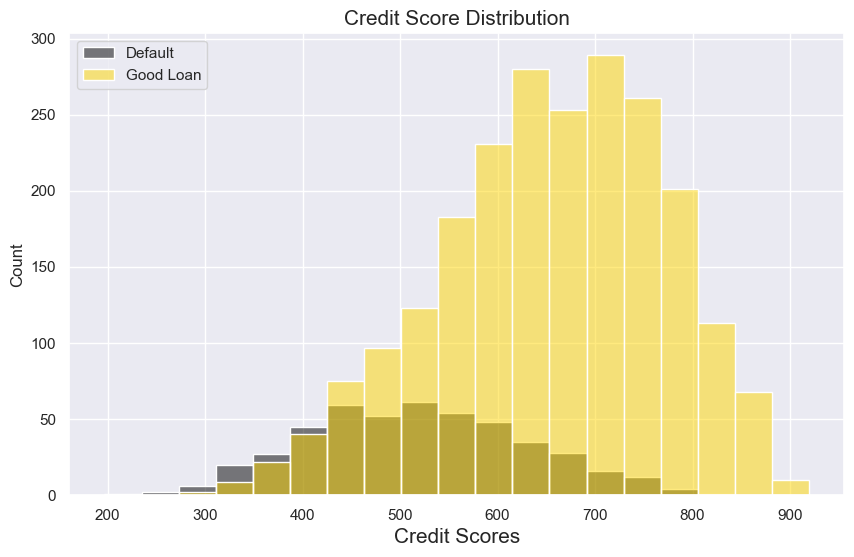

In [354]:
w = 40
n = math.ceil((df['CreditScore'].max() - df['CreditScore'].min())/w)

plt.figure(figsize=(10,6))
custom_colors = {1: "black", 0: "gold"}

sns.histplot(data=df, x='CreditScore', hue='TARGET', bins=n, palette=custom_colors)
plt.legend(['Default','Good Loan'], loc='upper left')
plt.title('Credit Score Distribution',size=15)
plt.xlabel('Credit Scores', fontsize=15)
plt.show()

# Threshold Tuning (Decile Method)

In [492]:
def get_credit_level(
    test,
    target_score ,
    out_col ,
    left_bound ,
    level_0 ,
    level_1 ,    
    level_2 ,    
    level_3 ,    
    level_4 ,    
    level_5 ,    
    level_6 ,
    level_7 ,
    level_8 ,
    level_9 ):
    
    level = []
    for i in range(len(test)):
        if (test[target_score][i]>left_bound) & (test[target_score][i]<=level_0):
            level.append(0)
        elif  (test[target_score][i]>level_0) & (test[target_score][i]<=level_1):
            level.append(1)
        elif  (test[target_score][i]>level_1) & (test[target_score][i]<=level_2):
            level.append(2)
        elif  (test[target_score][i]>level_2) & (test[target_score][i]<=level_3):
            level.append(3)
        elif  (test[target_score][i]>level_3) & (test[target_score][i]<=level_4):
            level.append(4)
        elif  (test[target_score][i]>level_4) & (test[target_score][i]<=level_5):
            level.append(5)
        elif  (test[target_score][i]>level_5) & (test[target_score][i]<=level_6):
            level.append(6)
        elif  (test[target_score][i]>level_6) & (test[target_score][i]<=level_7):
            level.append(7)
        elif  (test[target_score][i]>level_7 )& (test[target_score][i]<=level_8):
            level.append(8)
        elif  (test[target_score][i]>level_8 )& (test[target_score][i]<=level_9):
            level.append(9)
        elif  (test[target_score][i]>level_9 )& (test[target_score][i]<=level_10):
            level.append(10)

    test[out_col] = level
    return test

In [493]:
test_CreditScore = test['CreditScore'].sort_values().reset_index(drop=True)

Decile_1 = test_CreditScore.iloc[54]
Decile_2 = test_CreditScore.iloc[109]
Decile_3 = test_CreditScore.iloc[163]
Decile_4 = test_CreditScore.iloc[218]
Decile_5 = test_CreditScore.iloc[271]
Decile_6 = test_CreditScore.iloc[327]
Decile_7 = test_CreditScore.iloc[381]
Decile_8 = test_CreditScore.iloc[436]
Decile_9 = test_CreditScore.iloc[490]
Decile_10 = test_CreditScore.iloc[545]

print(Decile_1)
print(Decile_2)
print(Decile_3)
print(Decile_4)
print(Decile_5)
print(Decile_6)
print(Decile_7)
print(Decile_8)
print(Decile_9)
print(Decile_10)

453.57520383803995
518.4494108059222
565.8033954805201
600.4082745559143
633.8088776685776
663.2475873583999
696.6469943197432
734.7506485639393
780.9181780346993
919.4813438707024


In [495]:
test = get_credit_level(test,
                       target_score ='CreditScore',
                       out_col = 'CreditScore_level',
                      left_bound = -100,
    level_0 = Decile_1 ,
    level_1 = Decile_2 ,    
    level_2 = Decile_3 ,    
    level_3 = Decile_4 ,    
    level_4 = Decile_5 ,    
    level_5 = Decile_6 ,    
    level_6 = Decile_7 ,
    level_7 = Decile_8,
    level_8 = Decile_9,
    level_9 = Decile_10 )

test.head()

,DerogCnt,CollectCnt,BanruptcyInd,InqCnt06,InqTimeLast,InqFinanceCnt24,TLTimeFirst,TLTimeLast,TLCnt03,TLCnt12,...,TLSatPct,TLDel3060Cnt24,TLDel90Cnt24,TLDel60CntAll,TLOpenPct,TLBadDerogCnt,TLDel60Cnt24,TLOpen24Pct,CreditScore,CreditScore_level
0,0,0,0,0,24.0,1,133,16,0,0,...,0.5000,2,1,2,0.3750,1,2,0.6667,594.635725,3
1,0,0,0,1,1.0,1,340,3,1,2,...,0.4167,3,0,6,0.3333,0,1,0.3750,695.849759,6
2,3,3,0,4,0.0,5,117,27,0,0,...,0.2083,2,3,7,0.2083,4,4,0.0000,302.821674,0
3,1,0,0,4,1.0,7,187,3,2,3,...,0.5172,0,0,5,0.4483,1,0,0.6154,675.616445,6
4,0,0,0,6,0.0,10,96,14,0,0,...,0.4737,1,1,2,0.3684,1,1,0.4286,560.137453,2


In [498]:
test_df_final = pd.concat([test.reset_index(drop=True),y_test.reset_index(drop=True)], axis=1)
test_df_final.head()

,DerogCnt,CollectCnt,BanruptcyInd,InqCnt06,InqTimeLast,InqFinanceCnt24,TLTimeFirst,TLTimeLast,TLCnt03,TLCnt12,...,TLDel3060Cnt24,TLDel90Cnt24,TLDel60CntAll,TLOpenPct,TLBadDerogCnt,TLDel60Cnt24,TLOpen24Pct,CreditScore,CreditScore_level,TARGET
0,0,0,0,0,24.0,1,133,16,0,0,...,2,1,2,0.3750,1,2,0.6667,594.635725,3,0
1,0,0,0,1,1.0,1,340,3,1,2,...,3,0,6,0.3333,0,1,0.3750,695.849759,6,0
2,3,3,0,4,0.0,5,117,27,0,0,...,2,3,7,0.2083,4,4,0.0000,302.821674,0,1
3,1,0,0,4,1.0,7,187,3,2,3,...,0,0,5,0.4483,1,0,0.6154,675.616445,6,0
4,0,0,0,6,0.0,10,96,14,0,0,...,1,1,2,0.3684,1,1,0.4286,560.137453,2,1


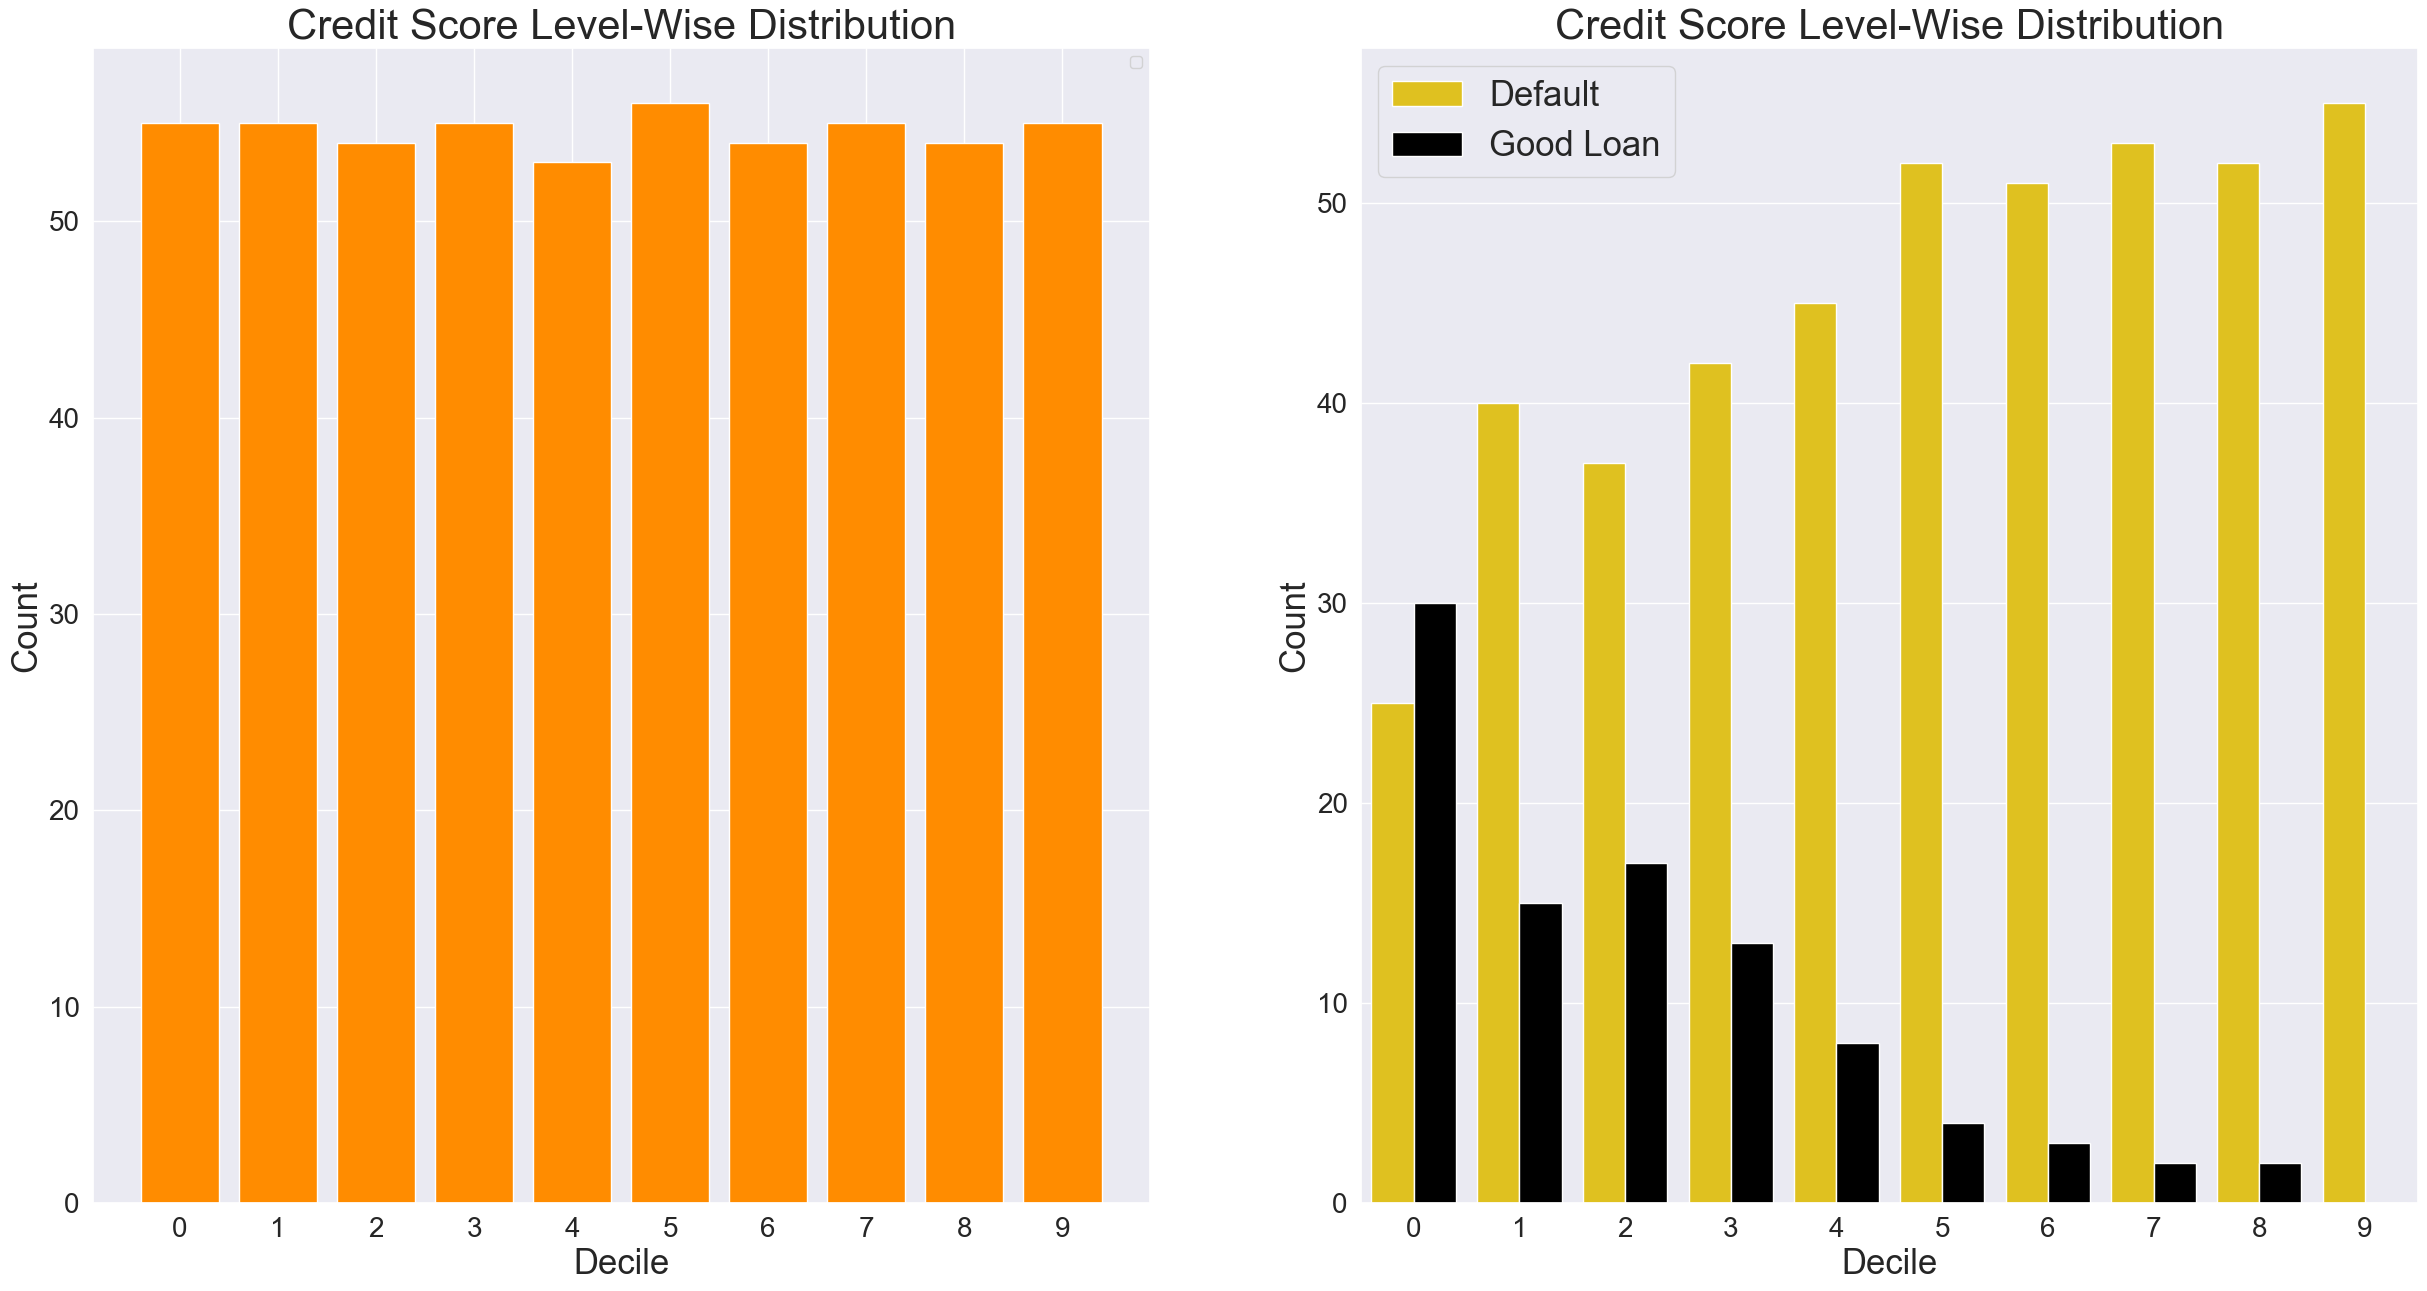

In [570]:
plt.figure(figsize=(30,15))

plt.subplot(1,2,1)
level_df = test['CreditScore_level'].value_counts()
level_df = pd.DataFrame(level_df)
plt.bar(level_df.index, level_df['CreditScore_level'], color='darkorange')
plt.title('Credit Score Level-Wise Distribution',size=30)
plt.legend(labels=[])
plt.xticks(range(10), fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.xlabel('Decile', fontsize=25)
plt.ylabel('Count', fontsize=25)

plt.subplot(1,2,2)
custom_colors = {1: "black", 0: "gold"}
sns.countplot(data=test_df_final.sort_values('CreditScore_level'), x='CreditScore_level', 
             hue='TARGET', palette=custom_colors, width=0.8)
plt.legend(['Default','Good Loan'], loc='upper left', fontsize=25)
plt.title('Credit Score Level-Wise Distribution',size=30)
plt.xlabel('Decile', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xticks(range(10),fontsize=20)
plt.yticks(fontsize=20)

plt.show()

### Loss & Coverage

* **Loss:** cumulative Fraction of Default Loans (Loss) in particular Decile
* **Coverage:** cumulative Fraction of Good Loans (Coverage) in particular Decile

In [561]:
def get_loss_coverage(test,target_level):

    L9_loss=test[test[target_level]>=9 ].TARGET.sum()/len(test[test[target_level]>=9 ])
    L9_coverage=test[test[target_level]>=9].TARGET.value_counts()[0]/test[test.TARGET==0].shape[0]
    print("Level9 - Level10: Loss is ",L9_loss, "; Coverage is ",L9_coverage)
    
    L8_loss=test[test[target_level]>=8 ].TARGET.sum()/len(test[test[target_level]>=8 ])
    L8_coverage=test[test[target_level]>=8].TARGET.value_counts()[0]/test[test.TARGET==0].shape[0]
    print("Level8 - Level10: Loss is ",L8_loss, "; Coverage is ",L8_coverage)    
    
    L7_loss=test[test[target_level]>=7 ].TARGET.sum()/len(test[test[target_level]>=7 ])
    L7_coverage=test[test[target_level]>=7].TARGET.value_counts()[0]/test[test.TARGET==0].shape[0]
    print("Level7 - Level10: Loss is ",L7_loss, "; Coverage is ",L7_coverage)
    
    L6_loss=test[test[target_level]>=6 ].TARGET.sum()/len(test[test[target_level]>=6 ])
    L6_coverage=test[test[target_level]>=6].TARGET.value_counts()[0]/test[test.TARGET==0].shape[0]
    print("Level6 - Level10: Loss is ",L6_loss, "; Coverage is ",L6_coverage)
    
    L5_loss = test[test[target_level]>=5 ].TARGET.sum()/len(test[test[target_level]>=5 ])
    L5_coverage=test[test[target_level]>=5 ].TARGET.value_counts()[0]/test[test.TARGET==0].shape[0]
    print("Level5 - Level10: Loss is ",L5_loss, "; Coverage is ",L5_coverage)
    
    L4_loss=test[test[target_level]>=4 ].TARGET.sum()/len(test[test[target_level]>=4 ])
    L4_coverage=test[test[target_level]>=4].TARGET.value_counts()[0]/test[test.TARGET==0].shape[0]
    print("Level4 - Level10: Loss is ",L4_loss, "; Coverage is ",L4_coverage)
    
    L3_loss=test[test[target_level]>=3].TARGET.sum()/len(test[test[target_level]>=3 ])
    L3_coverage=test[test[target_level]>=3].TARGET.value_counts()[0]/test[test.TARGET==0].shape[0]
    print("Level3 - Level10: Loss is ",L3_loss, "; Coverage is ",L3_coverage)
    
    L2_loss=test[test[target_level]>=2].TARGET.sum()/len(test[test[target_level]>=2 ])
    L2_coverage=test[test[target_level]>=2].TARGET.value_counts()[0]/test[test.TARGET==0].shape[0]
    print("Level2 - Level10: Loss is ",L2_loss, "; Coverage is ",L2_coverage)
    
    L1_loss=test[test[target_level]>=1].TARGET.sum()/len(test[test[target_level]>=1 ])
    L1_coverage=test[test[target_level]>=1].TARGET.value_counts()[0]/test[test.TARGET==0].shape[0]
    print("Level1 - Level10: Loss is ",L1_loss, "; Coverage is ",L1_coverage)
    
    L0_loss=test[test[target_level]>=0].TARGET.sum()/len(test[test[target_level]>=0 ])
    L0_coverage=test[test[target_level]>=0].TARGET.value_counts()[0]/test[test.TARGET==0].shape[0]
    print("Level0 - Level10: Loss is ",L0_loss, "; Coverage is ",L0_coverage)
    
    loss_coverage = { 'Decile': [10,9,8,7,6,5,4,3,2,1],
                     
                     'Cumulative_Loss': [L9_loss, L8_loss, L7_loss, L6_loss, L5_loss, 
                                         L4_loss, L3_loss, L2_loss, L1_loss, L0_loss ] ,
                     
                      'Cumulative_Coverage': [L9_coverage, L8_coverage, L7_coverage, L6_coverage, L5_coverage, 
                                              L4_coverage, L3_coverage, L2_coverage, L1_coverage, L0_coverage]
                       }
    loss_coverage_df = pd.DataFrame(loss_coverage)
    
    return loss_coverage_df

In [562]:
loss_coverage_df = get_loss_coverage(test_df_final,target_level='CreditScore_level')

Level9 - Level10: Loss is  0.0 ; Coverage is  0.12168141592920353
Level8 - Level10: Loss is  0.01834862385321101 ; Coverage is  0.23672566371681417
Level7 - Level10: Loss is  0.024390243902439025 ; Coverage is  0.35398230088495575
Level6 - Level10: Loss is  0.03211009174311927 ; Coverage is  0.4668141592920354
Level5 - Level10: Loss is  0.040145985401459854 ; Coverage is  0.581858407079646
Level4 - Level10: Loss is  0.0581039755351682 ; Coverage is  0.6814159292035398
Level3 - Level10: Loss is  0.08376963350785341 ; Coverage is  0.7743362831858407
Level2 - Level10: Loss is  0.11238532110091744 ; Coverage is  0.8561946902654868
Level1 - Level10: Loss is  0.13034623217922606 ; Coverage is  0.9446902654867256
Level0 - Level10: Loss is  0.17216117216117216 ; Coverage is  1.0


In [563]:
loss_coverage_df

,Decile,Cumulative_Loss,Cumulative_Coverage
0,10,0.000000,0.121681
1,9,0.018349,0.236726
2,8,0.024390,0.353982
3,7,0.032110,0.466814
4,6,0.040146,0.581858
5,5,0.058104,0.681416
6,4,0.083770,0.774336
7,3,0.112385,0.856195
8,2,0.130346,0.944690
9,1,0.172161,1.000000


#### According to business problem, the bank get +100 profit on a good loan and faces loss of -500 in a default case.

In [564]:
loss_coverage_df['Cumulative_Loss'] = loss_coverage_df['Cumulative_Loss']*100
loss_coverage_df['Cumulative_Coverage'] = loss_coverage_df['Cumulative_Coverage']*100

loss_coverage_df['Profit'] = loss_coverage_df['Cumulative_Coverage']*100 - loss_coverage_df['Cumulative_Loss']*500
loss_coverage_df

,Decile,Cumulative_Loss,Cumulative_Coverage,Profit
0,10,0.000000,12.168142,1216.814159
1,9,1.834862,23.672566,1449.825445
2,8,2.439024,35.398230,2320.310814
3,7,3.211009,46.681416,3062.637006
4,6,4.014599,58.185841,3811.284801
5,5,5.810398,68.141593,3908.960515
6,4,8.376963,77.433628,3554.881156
7,3,11.238532,85.619469,2942.680848
8,2,13.034623,94.469027,2929.591046
9,1,17.216117,100.000000,1391.941392


In [565]:
Decile_5

633.8088776685776

**Since Decile-5 has maximum net profit, So the bank should give loan to customers having credit score of 634 and above to get maximum profit.**